## Install dependencies


In [ ]:
pip install segment-geospatial groundingdino-py leafmap localtileserver

In [1]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

## Creating an interactive map
We have selected latitude and longitude from the area where major tree loss has occurred in Miami-Dade, according to Global Forest Watch (https://www.globalforestwatch.org/), by evaluating the provided color plot as is.

In [2]:
m = leafmap.Map(center=[25.40478, -80.68623], zoom=18, height="800px") # 25.40478, -80.68623
m.add_basemap("SATELLITE")
m

Map(center=[25.40478, -80.68623], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

## Download an image to segment trees



In [3]:
bbox = m.user_roi_bounds()

In [4]:
image1 = "Image1.tif"
tms_to_geotiff(output=image1, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

Downloaded image 01/16
Downloaded image 02/16
Downloaded image 03/16
Downloaded image 04/16
Downloaded image 05/16
Downloaded image 06/16
Downloaded image 07/16
Downloaded image 08/16
Downloaded image 09/16
Downloaded image 10/16
Downloaded image 11/16
Downloaded image 12/16
Downloaded image 13/16
Downloaded image 14/16
Downloaded image 15/16
Downloaded image 16/16
Saving GeoTIFF. Please wait...
Image saved to Image1.tif


## Initializing LangSAM class



In [5]:
sam = LangSAM()

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:28<00:00, 91.0MB/s]


## Providing text prompts.
In our case, it is Tree

In [6]:
text_prompt = "tree"

In [25]:
sam.predict(image1, text_prompt, box_threshold=0.22, text_threshold=0.24)

## Visualizing the Segmented Area for Trees
This evaluates the denser trees area




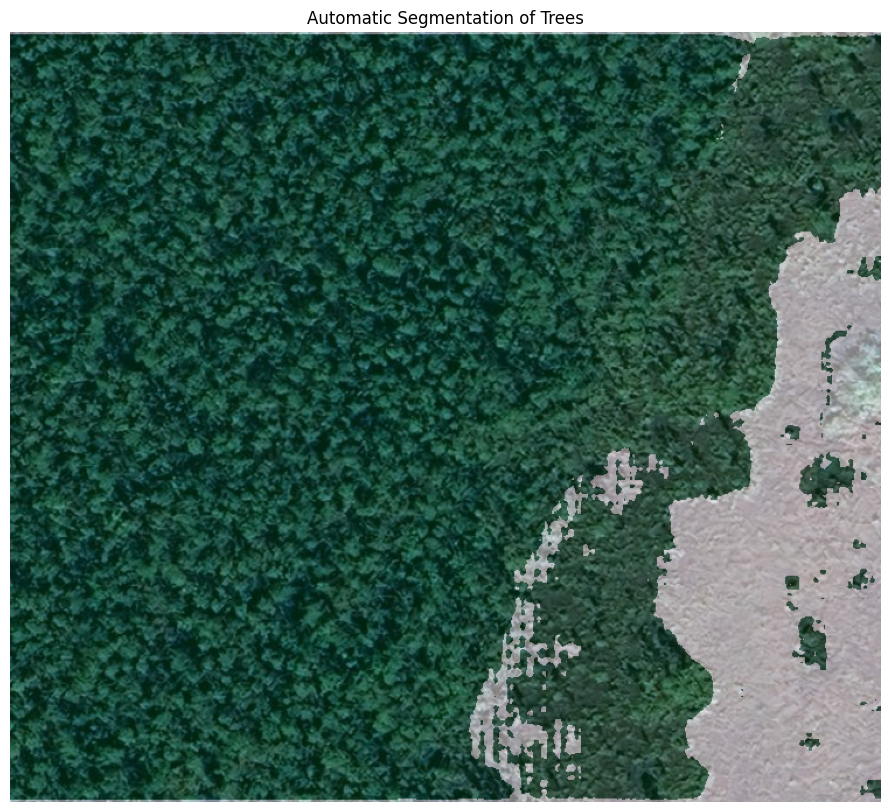

In [26]:
sam.show_anns(
    cmap="Greens",
    add_boxes=False,
    alpha=0.5,
    title="Automatic Segmentation of Trees",
)

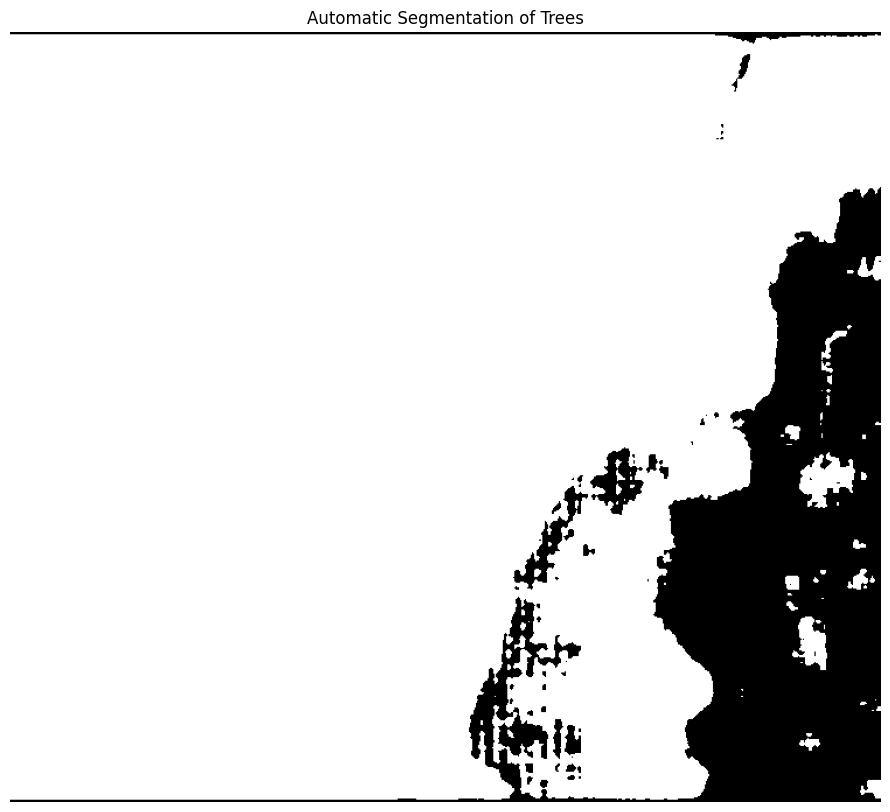

In [27]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Trees",
    blend=False,
    output="trees1.tif",  # Save segmented output
)

Converting the result to a vector format.  

In [ ]:
sam.raster_to_vector("trees.tif", "trees.shp")

Showing the segmentation on the interactive map.

In [ ]:
m.add_raster("trees.tif", layer_name="Trees", palette="Greens", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("trees.shp", layer_name="Vector", style=style)
m

Map(bottom=3582394.0, center=[25.40195, -80.6954], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Interactive segmentation with text prompts

In [ ]:
sam.show_map()

Map(center=[25.40195, -80.6954], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

## Segmenting in another area with few trees

In [9]:
m = leafmap.Map(center=[25.40478, -80.68623], zoom=18, height="800px") # 25.40478, -80.68623
m.add_basemap("SATELLITE")
m

Map(center=[25.40478, -80.68623], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [10]:
bbox = m.user_roi_bounds()

In [11]:
image2 = "Image2.tif"
tms_to_geotiff(output=image2, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

Downloaded image 1/9
Downloaded image 2/9
Downloaded image 3/9
Downloaded image 4/9
Downloaded image 5/9
Downloaded image 6/9
Downloaded image 7/9
Downloaded image 8/9
Downloaded image 9/9
Saving GeoTIFF. Please wait...
Image saved to Image2.tif


In [12]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


In [13]:
text_prompt = "tree"

In [28]:
sam.predict(image2, text_prompt, box_threshold=0.26, text_threshold=0.24) #increase box threshold when we have similar data to segment

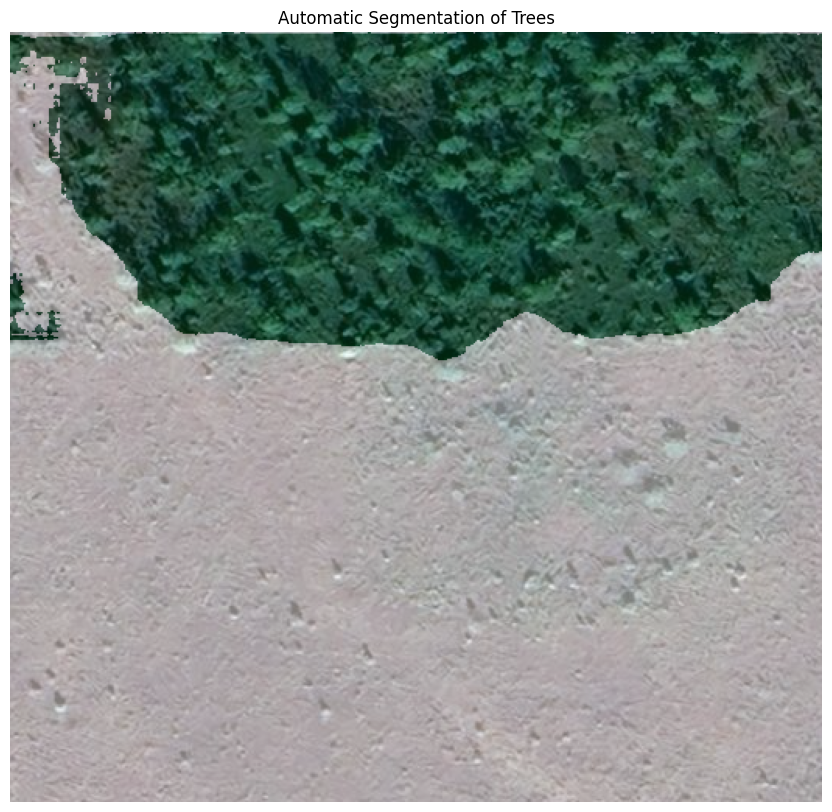

In [29]:
sam.show_anns(
    cmap="Greens",
    add_boxes=False,
    alpha=0.5,
    title="Automatic Segmentation of Trees",
)

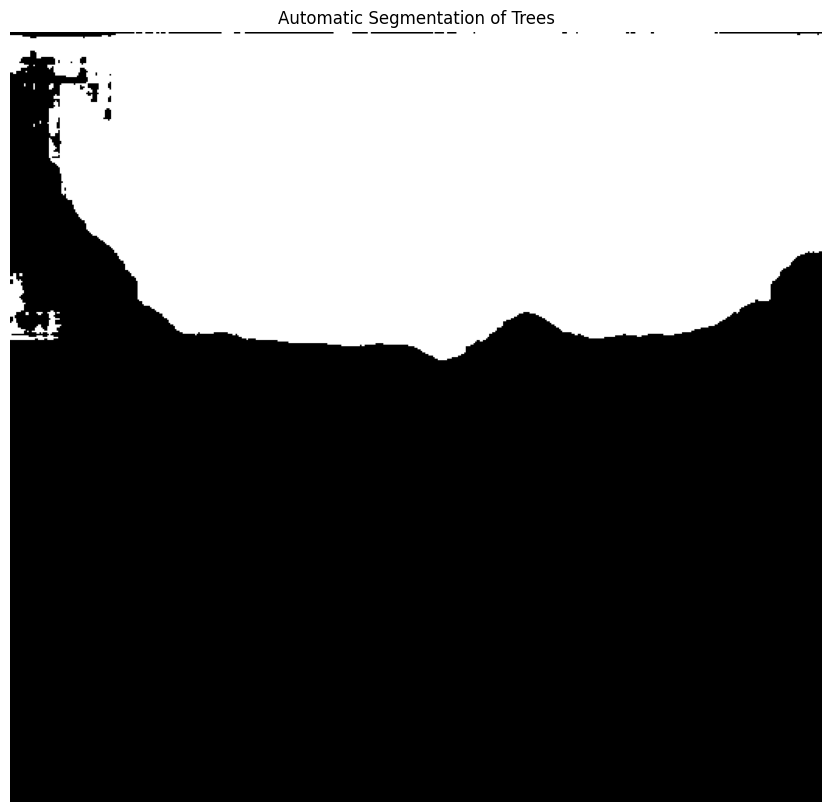

In [30]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Trees",
    blend=False,
    output="trees2.tif",  # Save segmented output
)

In [33]:
import numpy as np
import rasterio


# Function to compute segmented area
def compute_area(segmentation_mask, pixel_resolution):
    if segmentation_mask is None:
        return 0
    segmented_pixels = np.sum(segmentation_mask > 0)
    return segmented_pixels * pixel_resolution


image1 = "Image1.tif"
image2 = "Image2.tif"

# Reading segmentation masks from saved TIFF files
with rasterio.open("trees1.tif") as mask1, rasterio.open("trees2.tif") as mask2:
    mask1_data = mask1.read(1)  # grayscale image
    mask2_data = mask2.read(1)

#Computing pixel_resolution (meters per pixel)
with rasterio.open(image1) as src1, rasterio.open(image2) as src2:
    pixel_size1 = src1.res[0]
    pixel_area1 = pixel_size1 ** 2

    pixel_size2 = src2.res[0]
    pixel_area2 = pixel_size2 ** 2

# Compute area
area1 = compute_area(mask1_data, pixel_area1)
area2 = compute_area(mask2_data, pixel_area2)

# Compute difference
difference = area2 - area1
percentage_difference = ((difference / area1) * 100) if area1 != 0 else None

# Print results
print(f"Segmented Area in Image 1: {area1:.2f} m²")
print(f"Segmented Area in Image 2: {area2:.2f} m²")
print(f"Absolute Difference: {difference:.2f} m²")

if percentage_difference is not None:
    print(f"Percentage Difference: {percentage_difference:.2f}%")


Segmented Area in Image 1: 37109.64 m²
Segmented Area in Image 2: 8104.33 m²
Absolute Difference: -29005.32 m²
Percentage Difference: -78.16%


In [34]:
with rasterio.open(image1) as src:
    print(f"Resolution (meters per pixel): {src.res[0]:.5f} m")
    print(f"Coordinate Reference System (CRS): {src.crs}")


Resolution (meters per pixel): 0.29844 m
Coordinate Reference System (CRS): EPSG:3857
